In [ ]:
# default_exp datasets

# Data Simulation
The approach for creating simulated datasets is to initialize a model with specified parameters and experience sequences and then populate a psifr-formatted array with the outcomes of performing `free recall`. 

The `simulate_data` function below presumes each item is just presented once and that a model has already been initialized, and is better for quick baseline characterization of model performance. Datasets with item repetitions during presentation violate this premise; a more unique function is normally necessary for simulating these models in a performant way.

Since model simulation this way has always directly led to visualization in work done so far, a corresponding `trials` array is not produced.

## Demo Dependencies

In [ ]:
from compmemlearn.models import Classic_CMR
from compmemlearn.datasets import prepare_murdock1970_data, prepare_lohnas2014_data
from compmemlearn.analyses import fast_rpl, fast_spc
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numba import njit
import numpy.matlib

murd_trials0, murd_events0, murd_length0 = prepare_murdock1970_data('../../data/mo1970.txt')

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

cmr_result = np.array(
    [5.84259066e-01, 4.27375824e-03, 7.21454638e-01, 8.17704509e-01,
     1.00000000e+00, 9.88623591e-02, 9.31571732e+00, 7.54040329e+01,
     3.14204629e-02, 3.36598109e-01, 9.99452206e+00, 9.95457387e-01])

fitted_parameters = Dict.empty(
    key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

## Functions

### Pure List Simulation

In [ ]:
# export
import pandas as pd
from psifr import fr
import numpy as np
from numba import int32
from numba import njit

def simulate_df(model, experiment_count, first_recall_item=None):
    """
    Initialize a model with specified parameters and experience sequences and 
    then populate a psifr-formatted dataframe with the outcomes of performing `free recall`. 
    
    **Required model attributes**:
    - item_count: specifies number of items encoded into memory
    - context: vector representing an internal contextual state
    - experience: adding a new trace to the memory model
    - free_recall: function that freely recalls a given number of items or until recall stops
    """
    
    # encode items
    model.experience(model.items)

    # simulate retrieval for the specified number of times, tracking results in df
    data = []
    for experiment in range(experiment_count):
        data += [[experiment, 0, 'study', i + 1, i] for i in range(model.item_count)]
    for experiment in range(experiment_count):
        if first_recall_item is not None:
            model.force_recall(first_recall_item)
        data += [[experiment, 0, 'recall', i + 1, o] for i, o in enumerate(model.free_recall())]
        model.force_recall(0)
    data = pd.DataFrame(data, columns=['subject', 'list', 'trial_type', 'position', 'item'])
    merged = fr.merge_free_recall(data)
    
    return merged

What does it mean to simulate DF from events?

I want to simulate each trial as it happened in the dataset. I want to add the simulated data to my dataframe with the same index and other labels as they were given in the dataset.

In [ ]:
def simulate_df_from_events(model_class, parameters, events, trial_query, experiment_count, first_recall_item=None):

    

In [ ]:
from compmemlearn.datasets import events_metadata, generate_trial_mask

def simulate_df_from_events(model_class, parameters, events, trial_query, experiment_count, first_recall_item=None):
    """
    Initialize a model with specified parameters and experience sequences and 
    then populate a psifr-formatted dataframe with the outcomes of performing `free recall`. 
    
    **Required model attributes**:
    - item_count: specifies number of items encoded into memory
    - context: vector representing an internal contextual state
    - experience: adding a new trace to the memory model
    - free_recall: function that freely recalls a given number of items or until recall stops
    """

    trials, list_lengths, presentations = events_metadata(events)
    trial_mask = generate_trial_mask(events, trial_query)

    # confirm that only one list length was selected for this events df and trial_query
    trials = [
            trials[i][trial_mask[i]]
            for i in range(len(trials))
            if len(trials[i][trial_mask[i]]) > 0
        ]
    list_lengths = [list_lengths[i] for i in range(len(list_lengths)) if len(trials[i]) > 0]
    presentations = [presentations[i][trial_mask[i]] for i in range(len(presentations)) if len(trials[i]) > 0]
    assert(len(list_lengths) == 1)
    trials = trials[0]
    list_lengths = list_lengths[0]
    presentations = presentations[0]

    factors = []
    for column_name in events.columns[9:]:
        factors.append(
            events.pivot_table(index=['subject', 'list'], values=column_name, dropna=False).to_numpy()[trial_mask])
        assert(len(factors[-1]) == len(trials))

    # simulate retrieval for the specified number of times, tracking results in trials array
    trials = np.zeros((experiment_count * len(presentations), np.max(presentations)+1), dtype=int32)
    
    data = []
    for experiment in range(experiment_count):
        for trial_index in range(len(presentations)):
        
            # retrieve presentation sequence for this trial and measure number of unique items
            presentation = presentations[trial_index]
            for presentation_index, presentation_event in enumerate(presentation):
                data.append([
                    experiment, trial_index, 'study', presentation_index+1, presentation_event, presentation_index+1
                        ])
                for factor in factors:
                    data[-1].append(factor[presentation_index])
            item_count = np.max(presentation)+1
            
            # simulate recall and identify first study position of each recalled item
            model = model_class(item_count, len(presentation), parameters)
            model.experience(model.items[presentation])
            if first_recall_item is not None:
                model.force_recall(first_recall_item)
            recalled = model.free_recall()
            trial = [find_first(recalled[i], presentation) + 1 for i in range(len(recalled))]

            for recall_index, recall_event in enumerate(trial):
                if recall_event != 0:
                    data.append([
                        experiment, trial_index, 'recall', recall_index+1, presentation[recall_event-1], recall_event
                            ])
                    for factor in factors:
                        data[-1].append(factor[presentation_index])
    
    data = pd.DataFrame(data, columns=['subject', 'list', 'trial_type', 'position', 'item'] + events.columns[9:])
    merged = fr.merge_free_recall(data)
    return merged

In [ ]:
# export

@njit(fastmath=True, nogil=True)
def simulate_array(model, experiment_count, first_recall_item=None):
    
    # encode items
    model.experience(model.items)

    # simulate retrieval for the specified number of times, tracking results in array
    trials = np.zeros((experiment_count, len(model.items)), dtype=int32)
    
    for trial_index in range(len(trials)):
        
        recalled = model.free_recall()
        model.force_recall(0)
        trials[trial_index, :len(recalled)] = recalled + 1
        
    return trials

### Impure Lists (Possible Repetitions)

In [ ]:
# export

@njit(nogil=True)
def simulate_array_from_presentations(model_class, parameters, presentations, experiment_count):

    # simulate retrieval for the specified number of times, tracking results in trials array
    trials = np.zeros((experiment_count * len(presentations), np.max(presentations)+1), dtype=int32)
    
    for experiment in range(experiment_count):
        for trial_index in range(len(presentations)):
        
            # retrieve presentation sequence for this trial and measure number of unique items
            presentation = presentations[trial_index]
            item_count = np.max(presentation)+1
            
            # simulate recall and identify first study position of each recalled item
            model = model_class(item_count, len(presentation), parameters)
            model.experience(model.items[presentation])
            recalled = model.free_recall()
            
            for i in range(len(recalled)):
                trials[experiment*len(presentations) + trial_index, i] = find_first(recalled[i], presentation) + 1
    
    return trials

@njit(nogil=True)
def find_first(item, vec):
    """return the index of the first occurence of item in vec"""
    for i in range(len(vec)):
        if item == vec[i]:
            return i
    return -1

## Demo

### Mixed Lists: `simulate_array_from_presentations`
Make sure:
- presentation array is matched to trial array
- mixed list trials are selected
- experiment_count doesn't disrupt alignment

In [ ]:
trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

experiment_count = 1000

fit_sources = ['lohnas_all', 'lohnas_4', 'murdock1962', 'murdock1970']

fit_stats = [
    np.array([8.65828835e-01, 2.26715503e-01, 9.52028097e-01, 2.63844603e-02,
       1.47259363e-07, 4.31890546e-01, 2.63745217e+00, 2.98606729e+01,
       2.51644003e-02, 1.01406301e-01, 1.02305123e+00, 9.80106784e-01]),
    np.array([8.06135392e-01, 3.07112592e-01, 9.55038268e-01, 1.15022323e-01,
       1.60855931e-02, 5.07853225e-01, 4.61059897e-01, 7.16087569e+01,
       2.52322009e-02, 9.37792238e-02, 2.02696856e+00, 9.24630111e-01]),
    np.array([5.88304182e-01, 3.76144942e-02, 7.51294302e-01, 2.91680115e-01,
       1.00000000e+00, 1.39633721e-01, 5.62625588e+00, 4.28789782e+01,
       2.40537436e-02, 2.61824232e-01, 5.32941045e+00, 9.34036191e-01]),
    np.array([5.79524319e-01, 4.07083020e-03, 7.24717634e-01, 7.47425733e-01,
       1.00000000e+00, 9.58358158e-02, 9.55947397e+00, 8.71434638e+01,
       3.13827247e-02, 3.36754300e-01, 9.25336064e+00, 9.95710836e-01])
]

for i in range(len(fit_sources)):
    cmr_result = fit_stats[i]

    fitted_parameters = Dict.empty(
        key_type=types.unicode_type, value_type=types.float64)
    for j in range(len(cmr_result)):
        fitted_parameters[cmr_free_parameters[j]] = cmr_result[j]
        
    fitted_parameters['sampling_rule'] = 0
    fitted_parameters['mfc_familiarity_scale'] = 0
    fitted_parameters['mcf_familiarity_scale'] = 0
    fitted_parameters['drift_familiarity_scale'] = 0

    new_sim_array = simulate_array_from_presentations(init_cmr, fitted_parameters, presentations[list_types==4], experiment_count)
    
    result = fast_rpl(np.matlib.repmat(presentations[list_types==4], experiment_count, 1), new_sim_array)
    binned = np.zeros(5)
    binned[0] = result[0]
    binned[1] = result[1]
    binned[2] = (result[2] + result[3])/2
    binned[3] = (result[4] + result[5] + result[6])/3
    binned[4] = (result[7] + result[8] + result[9])/3
    print(fit_sources[i], ':')
    print(binned)
    print()

lohnas_all :
[0.35386862 0.43319286 0.46776964 0.48948095 0.49651786]

lohnas_4 :
[0.35961046 0.50194643 0.53528214 0.55109286 0.55234048]

murdock1962 :
[0.19713656 0.34533214 0.34188036 0.34759405 0.34767381]

murdock1970 :
[0.15170502 0.26838214 0.25996429 0.25957381 0.25287619]



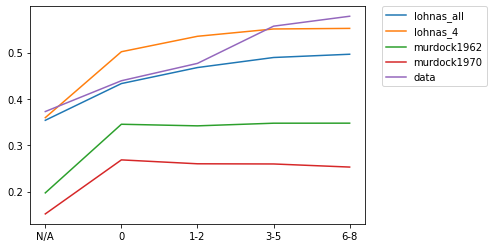

In [ ]:
fit_sources = ['lohnas_all', 'lohnas_4', 'murdock1962', 'murdock1970']

fit_rpls = [[0.35386862, 0.43319286, 0.46776964, 0.48948095, 0.49651786], 
            [0.35961046, 0.50194643, 0.53528214, 0.55109286, 0.55234048],
            [0.19713656, 0.34533214, 0.34188036, 0.34759405, 0.34767381],
            [0.15170502, 0.26838214, 0.25996429, 0.25957381, 0.25287619]]

for i in range(len(fit_sources)):
    plt.plot(fit_rpls[i], label=fit_sources[i])

result = fast_rpl(presentations[list_types==4], trials[list_types==4])
binned = np.zeros(5)
binned[0] = result[0]
binned[1] = result[1]
binned[2] = (result[2] + result[3])/2
binned[3] = (result[4] + result[5] + result[6])/3
binned[4] = (result[7] + result[8] + result[9])/3
plt.plot(binned, label='data')
lags = ['N/A', '0', '1-2', '3-5', '6-8']
plt.xticks(np.arange(len(lags)), lags)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Pure Lists: `simulate_df`

In [ ]:
model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)
sim_df = simulate_df(model, 1000)

sim_df.head()

,subject,list,item,input,output,study,recall,repeat,intrusion
0,0,0,0,1,NaN,True,False,0,False
1,0,0,1,2,NaN,True,False,0,False
2,0,0,2,3,NaN,True,False,0,False
3,0,0,3,4,NaN,True,False,0,False
4,0,0,4,5,2.0,True,True,0,False


### Pure Lists: `simulate_array` vs `simulate_array_from_presentations`

In [ ]:
# implementation that assumes pure lists
model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)
original_sim_array = simulate_array(model, len(murd_trials0))#*100)
original_spc = fast_spc(original_sim_array, murd_length0)

original_sim_array

array([[18, 14, 19, ...,  0,  0,  0],
       [17,  0,  0, ...,  0,  0,  0],
       [18,  1, 19, ...,  0,  0,  0],
       ...,
       [ 8, 20, 15, ...,  0,  0,  0],
       [15, 20, 17, ...,  0,  0,  0],
       [19, 20,  1, ...,  0,  0,  0]])

In [ ]:
# presentation-based implementation
presentations = np.zeros((len(murd_trials0), murd_length0), dtype=int)
presentations[:] = np.arange(murd_length0)

new_sim_array = simulate_array_from_presentations(init_cmr, fitted_parameters, presentations, 1)
new_spc = fast_spc(new_sim_array, murd_length0)

new_sim_array

array([[18, 20,  5, ...,  0,  0,  0],
       [13, 12,  8, ...,  0,  0,  0],
       [19, 20,  3, ...,  0,  0,  0],
       ...,
       [20, 19, 15, ...,  0,  0,  0],
       [17, 18, 14, ...,  0,  0,  0],
       [19,  1, 20, ...,  0,  0,  0]])

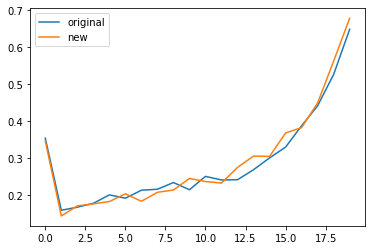

In [ ]:
# comparison
import matplotlib.pyplot as plt

plt.plot(fast_spc(original_sim_array, murd_length0), label='original')
plt.plot(fast_spc(new_sim_array, murd_length0), label='new')

plt.legend()